In [130]:
import pandas as pd
import json
import numpy as np
import cv2 as cv
import os

from functools import partial
import multiprocessing  
from multiprocessing import Pool

from classes import Class_device, Class_unity, Class_frame, Class_video, Class_pup

In [131]:
# nodige bestandslocaties
PUP = Class_pup()
# MP4
PUP.input_path_mp4 = 'PupilLabs_IO/input/world.mp4'
PUP.output_path_mp4 = 'PupilLabs_IO/output_MP4/world.mp4'
# CSV
PUP.input_path_csv = 'PupilLabs_IO/input/gaze_positions.csv' 
PUP.input_file_csv_fixations = 'PupilLabs_IO/input/fixations.csv' 
# PKL
PUP.output_path_pkl = 'PupilLabs_IO/output_PKL/' 
PUP.output_file_pkl_df_header = 'pkl_df_header.pkl' 
PUP.output_file_pkl_df_body = 'pkl_df_body.pkl' 

In [132]:
# frame properties ophalen
cap = cv.VideoCapture(PUP.input_path_mp4)

frame_obj = Class_frame()
frame_obj.width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_obj.height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
frame_obj.rate = int(cap.get(cv.CAP_PROP_FPS))
frame_obj.total = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

cap.release()
# frame_obj.number = df_body['frame_number'].iloc[:]

In [133]:
# video properties ophalen
video_obj =  Class_video()
video_obj.window_name = "Pupil Labs Core Eyetracker"
video_obj.input_file = PUP.input_path_mp4
video_obj.output_file = PUP.output_path_mp4
video_obj.nr_of_frames = frame_obj.total

In [134]:
df_body = pd.read_csv(PUP.input_path_csv)[['world_index', 'norm_pos_x', 'norm_pos_y']]
df_body = df_body.rename(columns = {'world_index': 'frame_number', 'norm_pos_x': 'px_eye_2d_x', 'norm_pos_y': 'px_eye_2d_y'})
df_body = df_body.drop_duplicates(subset = 'frame_number', keep = 'first').reset_index(drop=True)

df_body['px_eye_2d_x'] = (df_body['px_eye_2d_x'] * frame_obj.width).astype(int)
df_body['px_eye_2d_y'] = (df_body['px_eye_2d_y'] * frame_obj.height).astype(int)

df_body['px_eye_2d_y'] = frame_obj.height - df_body['px_eye_2d_y']

In [135]:
def checkFixation(frame, fixations):
    fixations = fixations[fixations['end_frame_index'] > frame['frame_number']]
    for index, row in fixations.iterrows():
        if frame['frame_number'] in range(row['start_frame_index'], row['end_frame_index']+1):
#             print(str(frame['frame_number']) + " 1", end="\r")
            return 1
#     print(str(frame['frame_number']) + " 0", end="\r")
    return 0

fixations = pd.read_csv(PUP.input_file_csv_fixations)
df_body['Fixation'] = df_body.apply(lambda frame: checkFixation(frame, fixations), axis=1) #fixaties toevoegen 

In [136]:
def labelimg(img, data):
    height, width, channels = img.shape

    # Detecting objects
    blob = cv.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Showing informations on the screen
    class_ids, confidences, boxes = [], [], []
    # confidences = []
    # boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.3:
                # Object detected
#                 print(class_id)
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                

    indexes = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
#     print(indexes)
    font = cv.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv.putText(img, label, (x, y + 30), font, 2, color, 2)

            if int(data["px_eye_2d_x"]) in range(x, x + w) and int(data["px_eye_2d_y"]) in range(y, y + h):
#                 print("looking at: %s        " % (label), end="\r")
                data["objectId"] = class_ids[i]
                data["object"] = classes[int(class_ids[i])]

    return img, data

In [137]:
def create_video(data, video, frame):
    if os.path.exists(video.output_file):
        os.remove(video.output_file)

    cv.namedWindow(video.window_name)

    cap = cv.VideoCapture(video.input_file)
    codec = cv.VideoWriter_fourcc('m', 'p', '4', 'v')
    out = cv.VideoWriter(video.output_file, codec, frame.rate, (frame.width, frame.height))  # MP4
    
    df_body["objectId"] = np.nan
    df_body["object"] = np.nan
    current_frame = 0
    try:
        while cap.isOpened():
            ret, img = cap.read()
            if ret is True and current_frame < video.nr_of_frames:
                if data['Fixation'][current_frame] == 1: #wel een fixation
                    img, serie = labelimg(img, data.iloc[[current_frame]])
                    data.iloc[[current_frame]] = serie
                    cv.circle(img, (data["px_eye_2d_x"][current_frame], data["px_eye_2d_y"][current_frame]), 30, (255, 255, 255), 3)
                if data['Fixation'][current_frame] == 0: #geen fixation
                    cv.circle(img, (data["px_eye_2d_x"][current_frame], data["px_eye_2d_y"][current_frame]), 30, (0, 0, 255), 3)
                
                out.write(img)
                cv.imshow(video.window_name, img)
                
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
                current_frame = current_frame + 1
            else:
                break

        cap.release()
        out.release()
        cv.destroyAllWindows()
    except Exception as e:
        print('error')
        print(e)
        cap.release()
        out.release()
        cv.destroyAllWindows()
    return data

In [138]:
#model goedzetten
net = cv.dnn.readNet("weights/TinyWeightsV4.weights", "configs/TinyConfig.cfg")  # weight en configuration file ophalen
classes = ["Jam", "Knife", "Bread", "Choco"]

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

df_body = create_video(df_body, video_obj, frame_obj)

c:\users\robbe brandse\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\robbe brandse\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [139]:
df_body

,frame_number,px_eye_2d_x,px_eye_2d_y,Fixation,objectId,object
0,0,596,738,0,NaN,NaN
1,1,602,738,1,0.0,Jam
2,2,608,728,1,0.0,Jam
3,3,607,728,1,0.0,Jam
4,4,608,727,1,0.0,Jam
...,...,...,...,...,...,...
2746,2746,541,217,1,NaN,NaN
2747,2747,549,217,1,NaN,NaN
2748,2748,553,224,0,NaN,NaN
2749,2749,558,222,0,NaN,NaN


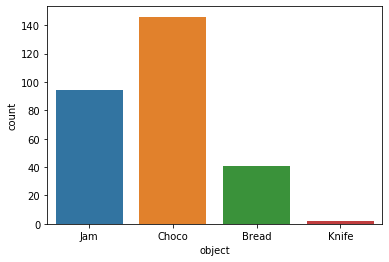

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data = df_body, x="object")

In [141]:
def interpolate(data, max_pointRange):
    previous_point = {"index": 0, "object": None}
    for index, row in data.iterrows():
        if previous_point['object'] == None and row['object'] != None:
            previous_point['object'] = row['object']
            previous_point['index'] = row['frame_number']

        if row['object'] != None:
            if previous_point['object'] == row['object']:
                if int(row['frame_number'] - previous_point['index']) in range(2, max_pointRange+1):
                    for frame in range(int(previous_point['index'] +1) , int(row['frame_number'])):
                        data.at[frame, "object"] = row['object']
                        data.at[frame, "objectId"] = classes.index(row['object'])

                previous_point['object'] = row['object']
                previous_point['index'] = row['frame_number']
    return data

df_body = interpolate(df_body, 1000)

In [142]:
def gantplot(df_body):
    usefull = df_body.dropna()
    viewed_classes = usefull['object'].unique()
    print(viewed_classes)
    graph_data = {}
    for classname in viewed_classes:
        graph_data[classname]= usefull[usefull['object'] == classname]
        
    fig, gnt = plt.subplots() 

    gnt.set_yticks(np.arange(10, len(viewed_classes)*10+1,10))
    gnt.set_yticklabels(viewed_classes) 
    gnt.set_xlabel('tijdverloop') 

    gnt.set_yticklabels(viewed_classes) 
    gnt.grid(True) 

    colors= ['tab:blue','tab:red','tab:purple','tab:orange']
    for key, val in graph_data.items():
        output = [(row['frame_number'], 1) for index, row in val.iterrows()]
        nr = list(viewed_classes).index(key)
        gnt.broken_barh(output, (nr*10 + 5, 10),facecolors =colors[nr] )
    plt.show()

['Jam' 'Choco' 'Bread' 'Knife']


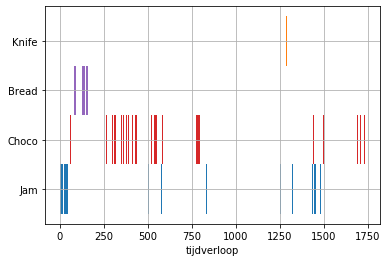

In [143]:
gantplot(df_body)